# Machine Learning

"*[Machine learning](https://github.com/georgetown-analytics/machine-learning/blob/master/notebook/Tour%20de%20SciKit-Learn.ipynb) can classically be summarized with two methodologies: supervised and unsupervised learning. In supervised learning, the “correct answers” are annotated ahead of time and the algorithm tries to fit a decision space based on those answers. In unsupervised learning, algorithms try to group like examples together, inferring similarities via distance metrics. Machine learning allows us to handle new data in a meaningful way, predicting where new data will fit into our models.*"

We will be conducting supervised learning. 

#### Potential Issues (List any issues as they occur)

**Null Values**
   * Sklearn doesn't deal handle *Null* values. 
   * While the data is fairly clean there are *Null* values that occur in the publication origin lagged variables. This is due to date ranges where there were no publication from a given county/region. Solutions:
      * Recode missing values to the mean or median.
      * Drop the values with missing data.  

In [1]:
%matplotlib inline

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn import cross_validation as cv

/Users/laurieottehenning/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Clean Training Data of Null values

Scikit-learn will expect numeric values and no blanks, so first we need to do a bit more wrangling.

In [2]:
# Import csv as a dataframe
path = "/Users/laurieottehenning/Documents/Georgetown Data Science /Capstone/Final Data Set"
os.chdir(path)
train = pd.read_csv('Final_Clean_Data.csv')

In [3]:
# Check that all of the data is there
train.columns

Index(['Unnamed: 0', 'Date', 'EventID', 'FinalRating', 'Day of Week',
       'Weekend Flag', 'year', 'month', 'Value_Average_Past_30_days', 'lag_30',
       'Value_Average_Past_14_days', 'lag_14', 'Value_Average_Past_7_days',
       'lag_7', 'Middle East lagpub_7', 'Other lagpub_7', 'UK lagpub_7',
       'US lagpub_7', 'Middle East lagpub_14', 'Other lagpub_14',
       'UK lagpub_14', 'US lagpub_14', 'Middle East lagpub_30',
       'Other lagpub_30', 'UK lagpub_30', 'US lagpub_30'],
      dtype='object')

In [4]:
train.head(3)

,Unnamed: 0,Date,EventID,FinalRating,Day of Week,Weekend Flag,year,month,Value_Average_Past_30_days,lag_30,...,UK lagpub_7,US lagpub_7,Middle East lagpub_14,Other lagpub_14,UK lagpub_14,US lagpub_14,Middle East lagpub_30,Other lagpub_30,UK lagpub_30,US lagpub_30
0,0,2010-01-03,NaN,5.0,Sunday,1,2010.0,1.0,NaN,-0.020080,...,NaN,-0.02008,NaN,NaN,NaN,-0.02008,NaN,NaN,NaN,-0.02008
1,1,2010-01-04,NaN,5.0,Monday,0,2010.0,1.0,-0.020080,0.006581,...,0.033242,NaN,NaN,NaN,0.033242,NaN,NaN,NaN,0.033242,NaN
2,2,2010-01-08,NaN,5.0,Friday,0,2010.0,1.0,0.006581,0.009730,...,0.024635,NaN,NaN,NaN,0.024635,NaN,NaN,NaN,0.024635,NaN


In [5]:
# Crosstab of ratings by year
print(pd.crosstab(train.year, train.FinalRating))

FinalRating  -1.0   0.0   1.0   2.0   3.0   5.0
year                                           
2010.0          0     0     0     0     0   159
2011.0         45     1    12    33    38   169
2012.0         32     2    23    37    37   229
2013.0          2     1     9    12    11   311
2014.0          7     1     6    12    12   323
2015.0          3     3     5    11    11   317
2016.0          4     3     8    13     9   315
2017.0          0     0     0     0     0     1


In [6]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*train.shape))

# Determine the frequency of each rating
print(train.groupby('FinalRating')['FinalRating'].count())

2227 instances with 26 features

FinalRating
-1.0      93
 0.0      11
 1.0      63
 2.0     118
 3.0     118
 5.0    1824
Name: FinalRating, dtype: int64


In [7]:
# Check number of missing values
train.isnull().sum()

Unnamed: 0                       0
Date                             0
EventID                       1824
FinalRating                      0
Day of Week                      0
Weekend Flag                     0
year                             0
month                            0
Value_Average_Past_30_days       8
lag_30                           8
Value_Average_Past_14_days       8
lag_14                           8
Value_Average_Past_7_days       11
lag_7                            8
Middle East lagpub_7           828
Other lagpub_7                 996
UK lagpub_7                    541
US lagpub_7                    757
Middle East lagpub_14          828
Other lagpub_14                996
UK lagpub_14                   541
US lagpub_14                   757
Middle East lagpub_30          828
Other lagpub_30                996
UK lagpub_30                   541
US lagpub_30                   757
dtype: int64

#### Fill null values

Will fill null values with the mean. *Not 100% sure if this is right or if I should fill with median or something else.* 

In [8]:
# Fill the null values with mean
cols = ['Value_Average_Past_30_days', 'lag_30',
       'Value_Average_Past_14_days', 'lag_14', 'Value_Average_Past_7_days',
       'lag_7', 'Middle East lagpub_7', 'Other lagpub_7', 'UK lagpub_7',
       'US lagpub_7', 'Middle East lagpub_14', 'Other lagpub_14',
       'UK lagpub_14', 'US lagpub_14', 'Middle East lagpub_30',
       'Other lagpub_30', 'UK lagpub_30', 'US lagpub_30']

for i in cols:
    train[i] = train[i].fillna(train[i].mean())

train.isnull().sum()

Unnamed: 0                       0
Date                             0
EventID                       1824
FinalRating                      0
Day of Week                      0
Weekend Flag                     0
year                             0
month                            0
Value_Average_Past_30_days       0
lag_30                           0
Value_Average_Past_14_days       0
lag_14                           0
Value_Average_Past_7_days        0
lag_7                            0
Middle East lagpub_7             0
Other lagpub_7                   0
UK lagpub_7                      0
US lagpub_7                      0
Middle East lagpub_14            0
Other lagpub_14                  0
UK lagpub_14                     0
US lagpub_14                     0
Middle East lagpub_30            0
Other lagpub_30                  0
UK lagpub_30                     0
US lagpub_30                     0
dtype: int64

In [9]:
# Drop these columns since they aren't useful to train on. 
cols = ['Unnamed: 0', 'Value_Average_Past_30_days', 'Value_Average_Past_14_days', 
       'Value_Average_Past_7_days']
for i in cols:
    train = train.drop([i], axis=1)
train.columns

Index(['Date', 'EventID', 'FinalRating', 'Day of Week', 'Weekend Flag', 'year',
       'month', 'lag_30', 'lag_14', 'lag_7', 'Middle East lagpub_7',
       'Other lagpub_7', 'UK lagpub_7', 'US lagpub_7', 'Middle East lagpub_14',
       'Other lagpub_14', 'UK lagpub_14', 'US lagpub_14',
       'Middle East lagpub_30', 'Other lagpub_30', 'UK lagpub_30',
       'US lagpub_30'],
      dtype='object')

In [10]:
# Keep the first 4 years so we can test on the last 2 years
mask = (train['Date'] > '2010-12-31') & (train['Date'] <= '2014-12-31')
mask2 = (train['Date'] > '2014-12-31')
test = train.loc[mask2]
train = train.loc[mask]

In [11]:
train['year'].value_counts().sort_values(ascending=True)

2011.0    298
2013.0    346
2012.0    360
2014.0    361
Name: year, dtype: int64

In [12]:
test['year'].value_counts().sort_values(ascending=True)

2017.0      1
2015.0    350
2016.0    352
Name: year, dtype: int64

In [13]:
# Reset index 
test.reset_index(inplace=True)

In [14]:
test[['Date', 'EventID', 'FinalRating']].loc[318:328]

,Date,EventID,FinalRating
318,2015-11-30,NaN,5.0
319,2015-12-01,12062.0,2.0
320,2015-12-02,NaN,5.0
321,2015-12-03,12063.0,2.0
322,2015-12-04,12065.0,0.0
323,2015-12-05,NaN,5.0
324,2015-12-06,NaN,5.0
325,2015-12-07,NaN,5.0
326,2015-12-08,NaN,5.0
327,2015-12-09,NaN,5.0


## LOGISTIC REGRESSION

A logistic regression mathematically calculates the decision boundary between the possibilities. It looks for a straight line that represents a cutoff that most accurately represents the training data.

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
# Initialize our algorithm
lr = LogisticRegression(random_state=1)

In [17]:
# Define our predictors
predictors = ['Weekend Flag', 'lag_30', 'lag_14', 'lag_7', 'Middle East lagpub_7', 
              'Other lagpub_7', 'UK lagpub_7', 'US lagpub_7', 'Middle East lagpub_14', 
              'Other lagpub_14', 'UK lagpub_14', 'US lagpub_14','Middle East lagpub_30', 
              'Other lagpub_30', 'UK lagpub_30','US lagpub_30']
expected  = train["FinalRating"]

# Train the algorithm using all the training data
lr.fit(train[predictors], expected)

# Make predictions using the training set -- where we already know the correct answers
predicted = lr.predict(train[predictors])

In [18]:
# Make predictions based on the test data
predictions = lr.predict(test[predictors])

# Frame the submissions
test_predictions = pd.DataFrame({
        "Date": test["Date"],
        "EventID": test["EventID"],
        "FinalRating": predictions
    })
test_predictions.loc[318:328]

,Date,EventID,FinalRating
318,2015-11-30,NaN,5.0
319,2015-12-01,12062.0,5.0
320,2015-12-02,NaN,5.0
321,2015-12-03,12063.0,5.0
322,2015-12-04,12065.0,5.0
323,2015-12-05,NaN,5.0
324,2015-12-06,NaN,5.0
325,2015-12-07,NaN,5.0
326,2015-12-08,NaN,5.0
327,2015-12-09,NaN,5.0


### Cross-Validation

In [19]:
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

In [20]:
X = train[['Weekend Flag', 'lag_30', 'lag_14', 'lag_7', 'Middle East lagpub_7', 
              'Other lagpub_7', 'UK lagpub_7', 'US lagpub_7', 'Middle East lagpub_14', 
              'Other lagpub_14', 'UK lagpub_14', 'US lagpub_14','Middle East lagpub_30', 
              'Other lagpub_30', 'UK lagpub_30','US lagpub_30']]
y = train["FinalRating"]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.2)
log_reg = lr.fit(X_train, y_train)

In [21]:
# Every estimator has a score method that can judge the quality of the 
# fit (or the prediction) on new data. Bigger is better.   
log_reg.score(X_test, y_test)

0.78388278388278387

In [22]:
from sklearn.metrics import classification_report

In [23]:
expected   = y_test
predicted  = log_reg.predict(X_test)
classificationReport = classification_report(expected, predicted)
print(classificationReport)

             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00        11
        1.0       0.00      0.00      0.00         5
        2.0       0.00      0.00      0.00        17
        3.0       0.00      0.00      0.00        26
        5.0       0.78      1.00      0.88       214

avg / total       0.61      0.78      0.69       273



/Users/laurieottehenning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## <span style="color:red">Discuss Problems</span>

   * The ony rating that was predicted with efficacy was 5.0 (i.e. nothing occurred on the given day)
   * The -1 rating isn't meaningful and should be dropped. 
   * We'll run a test with 5.0 dropped and see if the models is any more predictive.

### Clean data

In [32]:
# Import csv as a dataframe
path = "/Users/laurieottehenning/Documents/Georgetown Data Science /Capstone/Final Data Set"
os.chdir(path)
train = pd.read_csv('Final_Clean_Data.csv')

# Check number of missing values
train.isnull().sum()

# Fill the null values with mean
cols = ['Value_Average_Past_30_days', 'lag_30',
       'Value_Average_Past_14_days', 'lag_14', 'Value_Average_Past_7_days',
       'lag_7', 'Middle East lagpub_7', 'Other lagpub_7', 'UK lagpub_7',
       'US lagpub_7', 'Middle East lagpub_14', 'Other lagpub_14',
       'UK lagpub_14', 'US lagpub_14', 'Middle East lagpub_30',
       'Other lagpub_30', 'UK lagpub_30', 'US lagpub_30']

for i in cols:
    train[i] = train[i].fillna(train[i].mean())

train.isnull().sum()

# Drop these columns since they aren't useful to train on. 
cols = ['Unnamed: 0', 'Value_Average_Past_30_days', 'Value_Average_Past_14_days', 
       'Value_Average_Past_7_days']
for i in cols:
    train = train.drop([i], axis=1)
train.columns

# Keep the ratings equal to 0, 1, 2, 3. 
mask = (train['FinalRating'] >= 0) & (train['FinalRating'] < 4)
train = train.loc[mask]

# Keep the first 4 years so we can test on the last 2 years
mask = (train['Date'] > '2010-12-31') & (train['Date'] <= '2014-12-31')
mask2 = (train['Date'] > '2014-12-31')
test = train.loc[mask2]
train = train.loc[mask]

# Reset index 
test.reset_index(inplace=True)
test[['EventID', 'Date', 'FinalRating']].head(10)

,EventID,Date,FinalRating
0,11004.0,2015-01-25,3.0
1,11007.0,2015-01-27,2.0
2,11008.0,2015-01-28,3.0
3,11013.0,2015-02-17,2.0
4,11021.0,2015-02-24,2.0
5,11022.0,2015-02-27,3.0
6,11028.0,2015-03-16,2.0
7,11034.0,2015-03-31,2.0
8,11036.0,2015-04-01,2.0
9,11040.0,2015-04-19,1.0


### Run Logistic Model Again

In [30]:
# Initialize our algorithm
lr = LogisticRegression(random_state=1)

# Define our predictors
predictors = ['Weekend Flag', 'lag_30', 'lag_14', 'lag_7', 'Middle East lagpub_7', 
              'Other lagpub_7', 'UK lagpub_7', 'US lagpub_7', 'Middle East lagpub_14', 
              'Other lagpub_14', 'UK lagpub_14', 'US lagpub_14','Middle East lagpub_30', 
              'Other lagpub_30', 'UK lagpub_30','US lagpub_30']
expected  = train["FinalRating"]

# Train the algorithm using all the training data
lr.fit(train[predictors], expected)

# Make predictions using the training set -- where we already know the correct answers
predicted = lr.predict(train[predictors])

# Make predictions based on the test data
predictions = lr.predict(test[predictors])

# Frame the submissions
test_predictions = pd.DataFrame({
        "Date": test["Date"],
        "EventID": test["EventID"],
        "FinalRating": predictions
    })
test_predictions.head(10)

,Date,EventID,FinalRating
0,2015-01-25,11004.0,2.0
1,2015-01-27,11007.0,3.0
2,2015-01-28,11008.0,3.0
3,2015-02-17,11013.0,3.0
4,2015-02-24,11021.0,3.0
5,2015-02-27,11022.0,3.0
6,2015-03-16,11028.0,3.0
7,2015-03-31,11034.0,3.0
8,2015-04-01,11036.0,3.0
9,2015-04-19,11040.0,2.0


### Cross Validation again

In [33]:
X = train[['Weekend Flag', 'lag_30', 'lag_14', 'lag_7', 'Middle East lagpub_7', 
              'Other lagpub_7', 'UK lagpub_7', 'US lagpub_7', 'Middle East lagpub_14', 
              'Other lagpub_14', 'UK lagpub_14', 'US lagpub_14','Middle East lagpub_30', 
              'Other lagpub_30', 'UK lagpub_30','US lagpub_30']]
y = train["FinalRating"]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size = 0.2)
log_reg = lr.fit(X_train, y_train)

# Every estimator has a score method that can judge the quality of the 
# fit (or the prediction) on new data. Bigger is better.   
log_reg.score(X_test, y_test)

0.44

In [34]:
expected   = y_test
predicted  = log_reg.predict(X_test)
classificationReport = classification_report(expected, predicted)
print(classificationReport)

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         1
        1.0       0.00      0.00      0.00        11
        2.0       0.33      0.22      0.27        18
        3.0       0.47      0.90      0.62        20

avg / total       0.31      0.44      0.34        50



/Users/laurieottehenning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
# We'll select 50 trees and opt for 'out-of-bag' samples to estimate the generalization error.
rf = RandomForestClassifier(n_estimators=50, oob_score=True)

In [38]:
# Next split up the data with the 'train test split' method in the Cross Validation module
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# ...and then run the 'fit' method to build a forest of trees
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [39]:
rf.score(X_test, y_test)

0.26000000000000001

In [41]:
expected   = y_test
predicted  = rf.predict(X_test)
classificationReport = classification_report(expected, predicted)
print(classificationReport)

             precision    recall  f1-score   support

        1.0       0.33      0.15      0.21        13
        2.0       0.14      0.19      0.16        16
        3.0       0.36      0.38      0.37        21

avg / total       0.28      0.26      0.26        50



### Visualization

In [42]:
def plot_classification_report(cr, title='Classification report', cmap=plt.cm.Reds):

    lines = cr.split('\n')
    classes = []
    plotMat = []

    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    fig, ax = plt.subplots(1)
    fig = plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    
    for c in range(len(plotMat)+1):
        for r in range(len(classes)):
            try:
                txt = plotMat[r][c]
                ax.text(c,r,plotMat[r][c],va='center',ha='center')
            except IndexError:
                pass
            
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

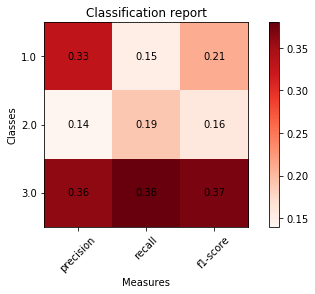

In [43]:
plot_classification_report(classificationReport)

## SVM
Support vector machines use points in transformed problem space to separate the classes into groups.

In [44]:
from sklearn.svm import SVC

In [45]:
kernels = ['linear', 'poly', 'rbf']

splits     = cross_validation.train_test_split(X,y, test_size=0.2)
X_train, X_test, y_train, y_test = splits

for kernel in kernels:
    if kernel != 'poly':
        model      = SVC(kernel=kernel)
    else:
        model      = SVC(kernel=kernel, degree=3)

model.fit(X_train, y_train)
expected   = y_test
predicted  = model.predict(X_test)

SVC_report = classification_report(expected, predicted)

/Users/laurieottehenning/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


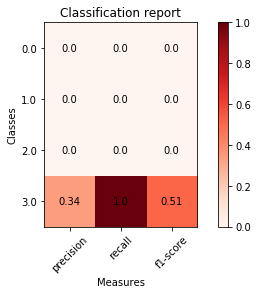

In [46]:
plot_classification_report(SVC_report)